# Trip evaluation and assignement

In [7]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel
from quetzal.io import excel

import pandas as pd

if manual:
    %matplotlib inline

input_folder = argv['training_folder'] + '/inputs/'
var = excel.read_var(file = input_folder + '/parameters.xlsx', scenario=argv['scenario'])

## Read Model

In [8]:
distribution = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/distribution'.format(scen=argv['scenario']))
pt = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/pruning_pt_pathfinder'.format(scen=argv['scenario']))
car = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/constrained_road_pathfinder'.format(scen=argv['scenario']))

sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes

# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

lines: 100%|██████████| 33/33 [00:00<00:00, 41.95it/s]           


# Preparation

In [9]:
# Add trip description to pt_los
sm.analysis_pt_los(walk_on_road=True)

path_analysis: 100%|██████████| 50898/50898 [00:00<00:00, 91354.70it/s] 


In [10]:
# Add trip time description to pt_los
sm.analysis_pt_time(walk_on_road=False)

In [11]:
# Logit Parameters
kwargs = var['preparation_logit'].to_dict()
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1}

In [12]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.00055,-1.0,-0.25,1.0
car_owner,-0.00055,-1.0,-0.25,1.0
pt_captive,-0.00055,-1.0,-0.25,1.0


In [13]:
sm.logit_scales.T

route_type,root,bus,tram,car,subway,walk,rail,pt
segment,,,,,,,,
root,1.0,0.1,0.1,0.0,0.1,0.0,0.1,0.5
car_owner,1.0,0.1,0.1,0.0,0.1,0.0,0.1,0.5
pt_captive,1.0,0.1,0.1,0.0,0.1,0.0,0.1,0.5


In [14]:
for segment in sm.segments:
    segment_utility = var.loc[(segment,sm.mode_utility.index)].droplevel(level=0)
    sm.mode_utility.loc[segment_utility.index,segment] = segment_utility.to_list()
    
sm.mode_utility = sm.mode_utility.fillna(0)
sm.mode_utility = sm.mode_utility*60*sm.utility_values.loc['time']
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type,root,bus,tram,car,subway,walk,rail
segment,,,,,,,
root,-0.0,-0.0000,-0.0,-0.00,-0.0000,-0.0,-0.0000
car_owner,-0.0,-0.3960,-0.0,-0.33,-0.0330,-0.0,-0.1485
pt_captive,-0.0,-0.0495,-0.0,-100.00,-0.0495,-0.0,-0.0165


In [15]:
sm.mode_nests.T # nested structure can be set for each segment

route_type,root,bus,tram,car,subway,walk,rail,pt
segment,,,,,,,,
root,NaN,pt,pt,root,pt,root,pt,root
car_owner,NaN,pt,pt,root,pt,root,pt,root
pt_captive,NaN,pt,pt,root,pt,root,pt,root


# Trips Utility Evaluation

In [16]:
sm.pt_los['price'] = 0
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type()

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p))
sm.analysis_mode_utility(how=var['analysis_mode_utility']['how'])

sm.los.head()

100%|██████████| 2/2 [00:00<00:00, 58.69it/s]


,origin,destination,gtime,path,pathfinder_session,reversed,route_id_set,route_type_set,broken_column,broken_route_type,...,footpath_time,in_vehicle_time,waiting_time,boarding_time,price,route_types,route_type,mode_utility,"(car_owner, utility)","(pt_captive, utility)"
0,zone_0,zone_0,-1.000000e+09,"(zone_0,)",best_path,False,{},{},NaN,NaN,...,0.0,0.0,0.0,0.0,0,(),walk,0.0000,0.000000,0.000000
1,zone_0,zone_1,8.960213e+02,"(zone_0, 244, zone_1)",best_path,False,{},{},NaN,NaN,...,0.0,0.0,0.0,0.0,0,(),walk,0.0000,-0.492812,-0.492812
2,zone_0,zone_10,1.413673e+03,"(zone_0, 244, link_3654, link_3655, link_3656,...",best_path,False,"{4, 95}","{bus, subway}",NaN,NaN,...,0.0,360.0,217.0,0.0,0,"(bus, subway)",subway,-0.0495,-1.060520,-1.077020
3,zone_0,zone_100,2.041824e+03,"(zone_0, 244, link_4303, link_4304, 170, link_...",best_path,False,"{1, 7}",{subway},NaN,NaN,...,0.0,780.0,285.0,0.0,0,"(subway,)",subway,-0.0495,-1.906003,-1.922503
4,zone_0,zone_101,1.604955e+03,"(zone_0, 244, link_4303, link_4304, 170, link_...",best_path,False,"{1, 7B}",{subway},NaN,NaN,...,0.0,600.0,298.0,0.0,0,"(subway,)",subway,-0.0495,-1.665725,-1.682225


## Calulate the probabilities and volume from trips utility (logit)

In [17]:
sm.step_logit(n_paths_max=10, workers=1, nchunks=10)
sm.compute_los_volume()

100%|██████████| 10/10 [00:00<00:00, 10.67it/s]


In [18]:
sm.step_assignment(
        road=True, 
        boardings=True, 
        alightings=True, 
        transfers=True,
        segmented=False,
        boarding_links=True,
        alighting_links=True)

# Export 

In [19]:
sm.to_zippedpickles(argv['training_folder'] + '/model/{scen}/logit'.format(scen=argv['scenario']))

utilities: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]     


In [20]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt

# XLSX EXPORT

In [25]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
#sm.summary_od(inplace=True)

#sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

KeyError: 'in_vehicle_length'

In [168]:
sm.to_excel(argv['training_folder'] + r'model/%s/stacks.xlsx'%scenario, prefix='stack')

# ZIP EXPORT

# PLOT

In [28]:
import numpy as np
paths = sm.los[sm.los['route_type'] != 'car']
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


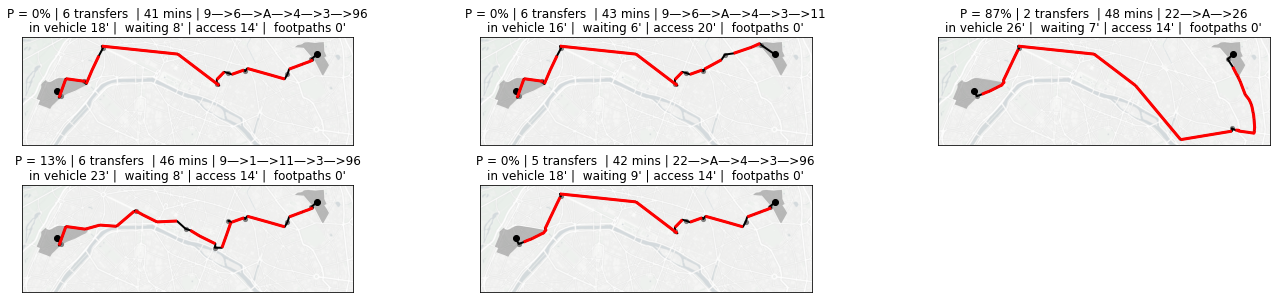

In [30]:
if manual:
    sm.pt_los = paths.copy()
    origin, destination='zone_74',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)

    url = 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

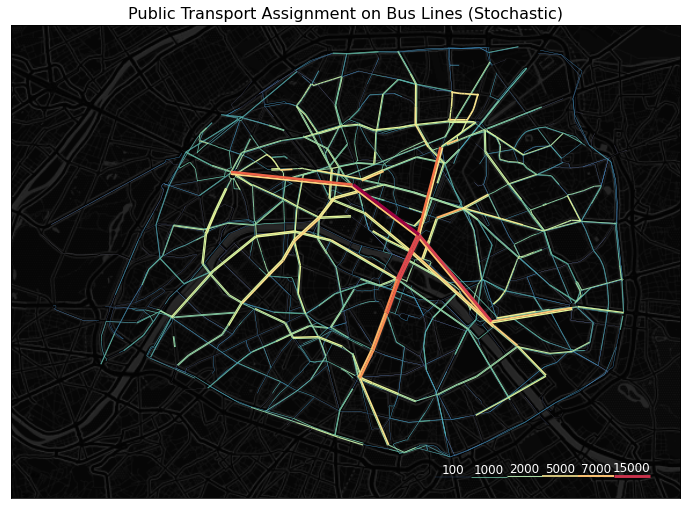

In [31]:
if manual:
    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000, 15000]
    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/{z}/{x}/{y}.png'

    sm.road_links['volume'] = sm.road_links[('volume', 'pt')]
    i_links = sm.links.loc[sm.links.road_length.isnull()]
    df = pd.concat([i_links, sm.road_links])
    df = df.loc[df['volume'] > 0]

    plot= bandwidth(
        df, value_column='volume', power=power, figsize=[12, 12], legend_values=lv,
        label_kwargs={'color':'white', 'fontsize':12}
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title('Public Transport Assignment on Bus Lines (Stochastic)', fontsize=16)